In [18]:
%load_ext autoreload
%autoreload 2
from configs import project_config
import pickle
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.Markovian_fQuadSinHF.recursive_Markovian_PostMeanScore_fQuadSinHF2_LowFTh_T256_H05_tl_110data_StbleTgt import get_config
#from configs.RecursiveVPSDE.Markovian_fSinLog.recursive_Markovian_PostMeanScore_fSinLog_LowFTh_T256_H05_tl_110data_StbleTgt import get_config
#from configs.RecursiveVPSDE.Markovian_fBiPot.recursive_Markovian_PostMeanScore_fBiPot_LowFTh_T256_H05_tl_110data_StbleTgt import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
config = get_config()
assert config.feat_thresh == 1.

In [20]:
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

In [21]:
def rmse_ignore_nans(y_true, y_pred):
    return np.nanmean((y_true-y_pred)**2)

def plot_drift_estimator(mean, mean_min, mean_max, numpy_Xs, true_drift, Nepoch, dirname, label, toSave: bool = True):
    if "BiPot" in config.data_path:
        ts_type_str = "fBiPot"
    elif "SinLog" in config.data_path:
        ts_type_str = "fSinLog"
    elif "QuadSinHF" in config.data_path:
        ts_type_str = "fQuadSinHF2"
    fig, ax = plt.subplots(figsize=(14, 9))
    ax.scatter(numpy_Xs, true_drift, color="red", label="True Drift")
    ymin = mean - mean_min
    ymax = mean_max - mean
    ymin[ymin < 0.] = 0.
    ymax[ymax < 0.] = 0.
    plt.errorbar(numpy_Xs, mean, yerr=[ymin, ymax], xerr=None, fmt='o', color="blue", alpha=0.4)
    plt.scatter(numpy_Xs, mean, label="Estimated Drift", color="blue")
    ax.set_title(rf"Score Estimator for {label}", fontsize=40)
    ax.tick_params(labelsize=38)
    ax.set_xlabel("State $Y$", fontsize=38)
    ax.set_ylabel("Drift Value", fontsize=38)
    ax.legend(fontsize=24)
    plt.grid(True)
    plt.tight_layout()
    if toSave:
        plt.savefig((root_dir +f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{ts_type_str}_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFac").replace(
                ".", "") + ".png", bbox_inches='tight')
    plt.show()
    plt.close()
def plot_ewma_losses(epochs, losses):
    start_idx = 50
    def compute_ema(loss_tensor, beta):
        ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
        ema_values[0] = loss_tensor[0]  # First value stays the same

        for i in range(1, len(loss_tensor)):
            ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

        return ema_values
    # Define EMA decay rates
    beta_short = 0.9   # Short-term trend (reacts quickly)
    beta_long = 0.92   # Long-term trend (smoother)

    # Compute EMAs
    short_term_ema = compute_ema(losses, beta_short)
    long_term_ema = compute_ema(losses, beta_long)
    plt.scatter(epochs[start_idx:], (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
    print(np.min(short_term_ema[start_idx:]), np.min(long_term_ema[start_idx:]))
    print(long_term_ema[-1])
    plt.yscale("log")
    plt.legend()
    plt.show()
    plt.scatter(epochs[start_idx:], (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()
    return long_term_ema

In [22]:
config = get_config()
#assert config.enforce_fourier_mean_reg
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"

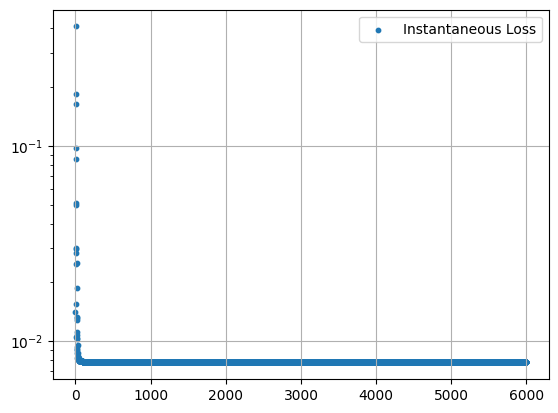

5999

In [23]:
with open((config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/")+ "_loss"), 'rb') as f:
        losses = (np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])
plt.scatter(Nepochs_losses,  losses, s=10, label="Instantaneous Loss")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()
plt.close()
Nepochs_losses[-1]

0.007779226215314589 0.007779333093458417
0.007779826479017512


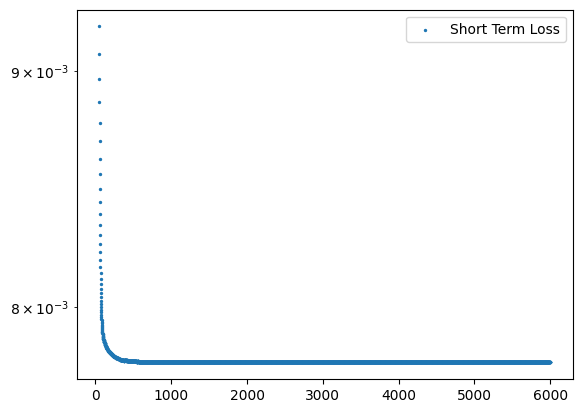

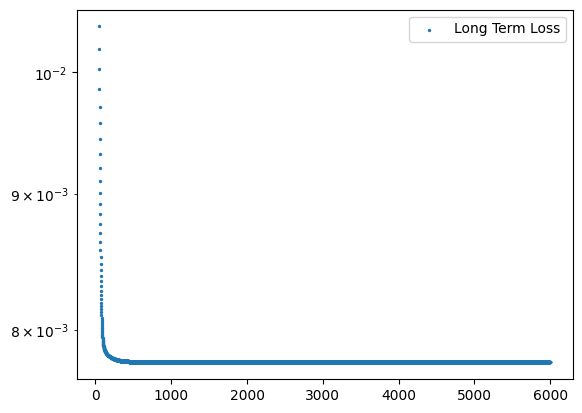

In [24]:
long_term_ema = plot_ewma_losses(epochs=Nepochs_losses, losses=losses)

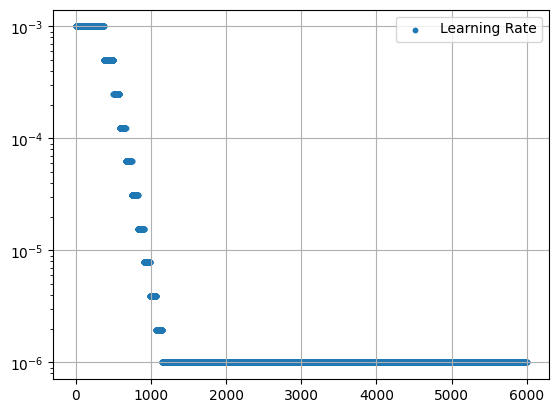

In [25]:
with open((config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/")+ "_loss_LR"), 'rb') as f:
        LRs = (np.array(pickle.load(f)).astype(float))
start = 0
end = -1
plt.scatter(np.arange(LRs.shape[0]),  LRs, s=10, label="Learning Rate")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()
plt.close()

In [26]:
root_score_dir = ""
if "fQuadSin" in config.data_path:
    minx = -1.5
    assert config.sin_space_scale == 25.
    ts_type = "fQuadSin"
    include = (f"{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c").replace(
        ".", "")
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/QuadSinHFLessData/"
elif "fBiPot" in config.data_path:
    minx = -1.5
    ts_type = "fBiPot"
    include = (f"{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c").replace(
        ".", "")
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/BiPotLessData/"
elif "fSinLog" in config.data_path:
    minx = -1.5
    ts_type = "fSinLog"
    include = (f"{config.deltaT:.3e}dT_{config.log_space_scale}b_{config.sin_space_scale}c").replace(
        ".", "")
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/SinLogLessData/"
maxx = -minx

In [27]:
root_score_dir

'/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/QuadSinHFLessData/'

In [30]:
NSTgt = "NSTgt" if not config.stable_target else ""
NSTgt += "NFMReg_" if not config.enforce_fourier_mean_reg else ""
if "BiPot" in config.data_path:
    ts_type_str = f"ST_{config.feat_thresh:.3f}FTh_{NSTgt}fBiPot".replace(".", "")
    dirname = "BiPot"
    label = "$\mu_{3}$"
elif "QuadSinHF" in config.data_path:
    ts_type_str = f"ST_{config.feat_thresh:.3f}FTh_{NSTgt}fQuadSinHF".replace(".","")
    dirname = "QuadSinHF"
    label = "$\mu_{2}$"
elif "SinLog" in config.data_path:
    ts_type_str = f"ST_{config.feat_thresh:.3f}FTh_{NSTgt}fSinLog".replace(".","")
    dirname = "SinLog"
    label = "$\mu_{1}$"

In [31]:
import pandas as pd
root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/{dirname}LessData/"
mses=[]
for file in os.listdir(root_score_dir):
    if "MSE" in file and "Diff01" not in file and "Diff100" not in file:
        print(file)
        mses.append(pd.read_parquet(root_score_dir+file, engine="fastparquet"))
mses = pd.concat(mses).reset_index(drop=False).rename({"index":"epoch"}, axis=1).sort_values("epoch").reset_index(drop=True)
Nepochs_track = mses["epoch"].values.flatten()

TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fQuadSinHF_DriftEvalExp_1296Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats_MSE.parquet
TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fQuadSinHF_DriftEvalExp_3807Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats_MSE.parquet
TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fQuadSinHF_DriftEvalExp_5448Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats_MSE.parquet
TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fQuadSinHF_DriftEvalExp_1146Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats_MSE.parquet
TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fQuadSinHF_DriftEvalExp_2682Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats_MSE.parquet
TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fQuadSinHF_DriftEvalExp_5157Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats_MSE.parquet
TSPM_MLP_ST_1000FTh_NSTgtNFMReg_fQuadSinHF_DriftEvalExp_3612Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats_MSE.parquet
TSPM_M

In [32]:
common_epochs = np.intersect1d(Nepochs_losses, Nepochs_track)
common_epochs = np.intersect1d(common_epochs, np.arange(100, 30000))
start_idx = 0
common_epochs = common_epochs[start_idx:]
losses_idx = np.unique([np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs])
track_idx = np.unique([np.argwhere(c == Nepochs_track)[0,0] for c in common_epochs])
red_losses = losses[losses_idx]
print(track_idx.shape, common_epochs.shape)
#track_rmses = np.array(list(drift_track_rmses.values()))[track_idx]
track_rmses = mses.iloc[track_idx,:].mse.values.flatten()
eval_rmses = track_rmses
print(track_rmses.shape, common_epochs.shape)

(1982,) (1982,)
(1982,) (1982,)


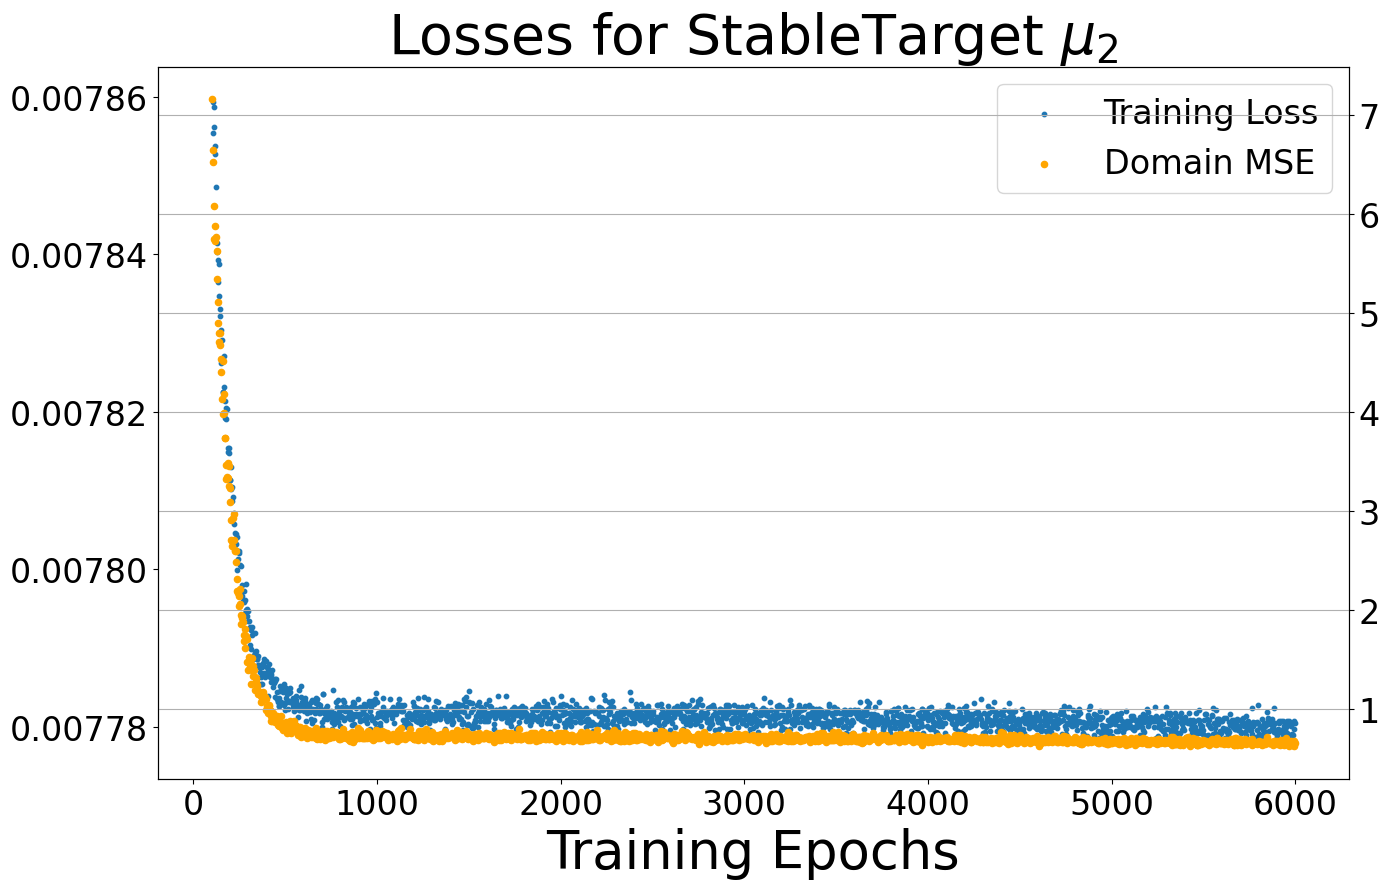

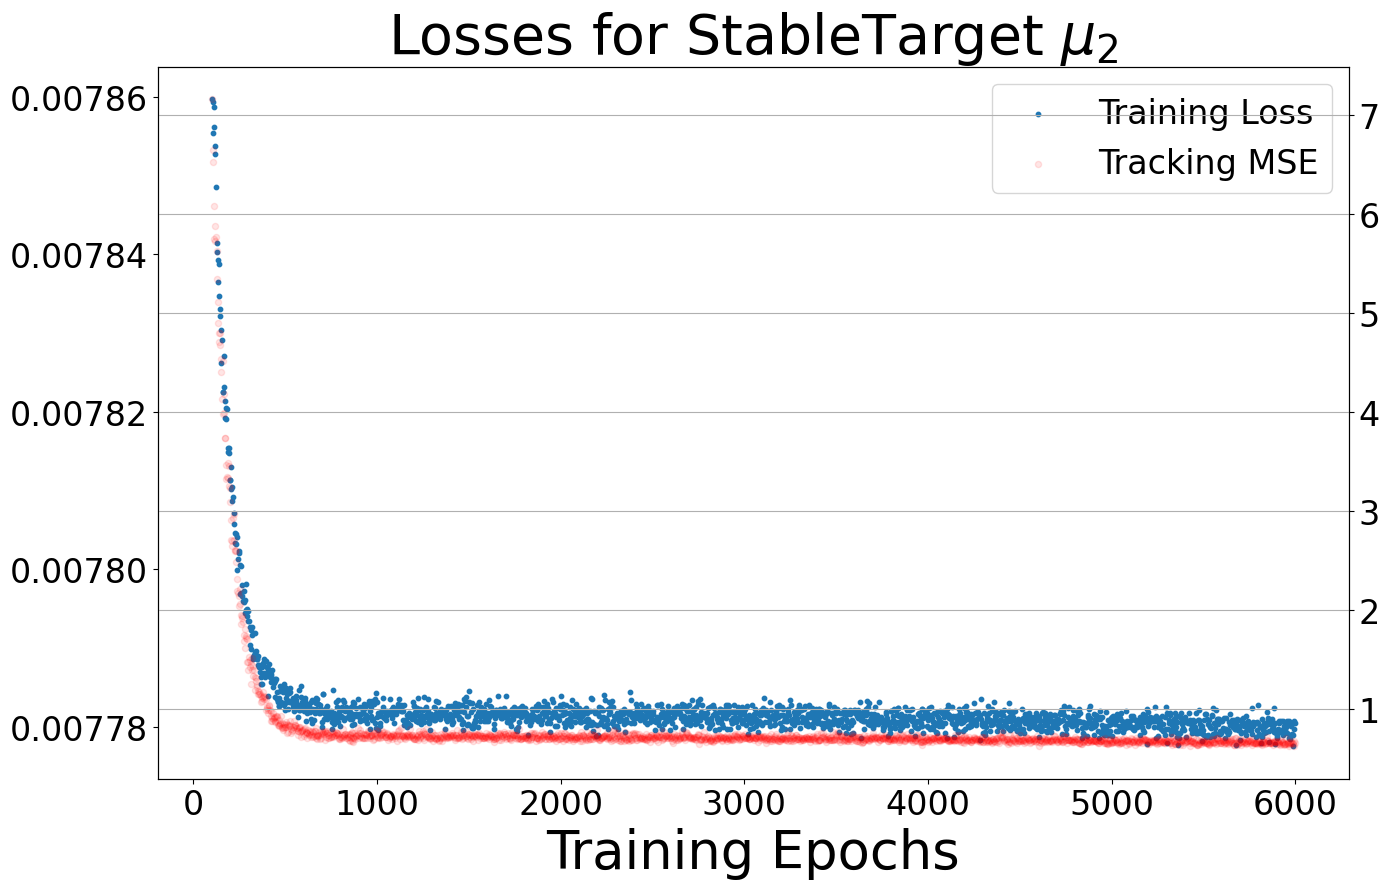

      epoch           mse
0         1  25639.296737
1         2   1315.986413
2         3   3782.749619
3         6   4394.311438
4         7   1269.582311
...     ...           ...
2017   5988      0.654555
2018   5991      0.681739
2019   5994      0.628912
2020   5997      0.657939
2021   6000      0.651898

[2022 rows x 2 columns]


In [33]:
toSave = False
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax.tick_params(axis="both",labelsize=24)
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, eval_rmses, s=20, color="orange",label="Domain MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(rf"Losses for StableTarget {label}", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
ax.legend(handles, labels, fontsize=24)
plt.grid(True)
plt.show()
plt.close()
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, track_rmses,alpha=0.1, s=20, color="red",label="Tracking MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(rf"Losses for StableTarget {label}", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
plt.grid(True)
plt.show()
plt.close()
print(mses)